In [28]:
import os
import re
import glob
import numpy as np
import pandas as pd
import numpy as np
import scipy.io as sio
import spikeinterface.extractors as se
import spikeinterface as si
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
from pathlib import Path
import matplotlib.pyplot as plt
import json

from typing import List, Tuple

In [29]:
ROOT_SORT_DIR = "/media/ubuntu/sda/cen/sorted_results/0912_250912_144124-麻醉状态10分钟/phy_folder_for_kilosort"

# 需要的 cluster 指标文件（来自 phy_folder_for_kilosort）
CLUSTER_INFO_FILENAME = "cluster_info.tsv"

SPIKE_CLUSTERS_FILENAME = "spike_clusters.npy"
SPIKE_TIMES_FILENAME = "spike_times.npy"

In [ ]:
def load_cluster_info(phy_dir: str) -> pd.DataFrame:
    """读取 phy_folder_for_kilosort/cluster_info.tsv 为 DataFrame。
    该表包含所有需要的 cluster 级指标。
    如果cluster_info.tsv不存在，则尝试从其他文件构建基本信息。
    同时计算并添加mean_waveform信息。
    """
    path = os.path.join(phy_dir, CLUSTER_INFO_FILENAME)
    
    if os.path.exists(path):
        df = pd.read_csv(path, sep='\t')
        # 标准化主键列名
        if 'cluster_id' not in df.columns:
            raise ValueError(f"{path} 中缺少 cluster_id 列")
    else:
        print(f"警告: {path} 不存在，尝试从其他文件构建cluster信息")
        
        # 尝试从cluster_group.tsv构建基本信息
        cluster_group_path = os.path.join(phy_dir, "cluster_group.tsv")
        if os.path.exists(cluster_group_path):
            df = pd.read_csv(cluster_group_path, sep='\t')
            if 'cluster_id' not in df.columns:
                raise ValueError(f"{cluster_group_path} 中缺少 cluster_id 列")
        else:
            # 如果都没有，从spike_clusters.npy中提取唯一的cluster_id
            spike_clusters_path = os.path.join(phy_dir, SPIKE_CLUSTERS_FILENAME)
            if os.path.exists(spike_clusters_path):
                spike_clusters = np.load(spike_clusters_path)
                unique_clusters = np.unique(spike_clusters)
                df = pd.DataFrame({
                    'cluster_id': unique_clusters,
                    'group': 'unsorted'  # 默认分组
                })
            else:
                raise ValueError(f"无法找到任何cluster信息文件: {phy_dir}")
    
    # 计算mean_waveform并展开为多列添加到DataFrame
    mean_waveforms = compute_mean_waveform(phy_dir)
    if mean_waveforms:
        # 确定waveform的长度（通常是90个时间点）
        waveform_length = None
        for waveform in mean_waveforms.values():
            if waveform is not None:
                waveform_length = len(waveform)
                break
        
        if waveform_length is not None:
            # 创建waveform列名
            waveform_columns = [f'mean_waveform_{i}' for i in range(waveform_length)]
            
            # 为每个cluster创建waveform数据
            waveform_data = {}
            for cluster_id in df['cluster_id']:
                if cluster_id in mean_waveforms and mean_waveforms[cluster_id] is not None:
                    waveform = mean_waveforms[cluster_id]
                    # 确保waveform长度一致
                    if len(waveform) == waveform_length:
                        waveform_data[cluster_id] = waveform
                    else:
                        # 如果长度不匹配，用NaN填充或截断
                        padded_waveform = np.full(waveform_length, np.nan)
                        padded_waveform[:min(len(waveform), waveform_length)] = waveform[:min(len(waveform), waveform_length)]
                        waveform_data[cluster_id] = padded_waveform
                else:
                    # 没有waveform数据的cluster用NaN填充
                    waveform_data[cluster_id] = np.full(waveform_length, np.nan)
            
            # 将waveform数据转换为DataFrame并合并
            waveform_df = pd.DataFrame.from_dict(waveform_data, orient='index', columns=waveform_columns)
            waveform_df.index.name = 'cluster_id'
            waveform_df = waveform_df.reset_index()
            
            # 合并到主DataFrame
            df = df.merge(waveform_df, on='cluster_id', how='left')
            print(f"成功添加mean_waveform信息到 {len(mean_waveforms)} 个clusters，展开为 {waveform_length} 列")
        else:
            print("警告: 无法确定waveform长度")
    else:
        print("警告: 无法计算mean_waveform信息")
    
    return df


def load_spike_level(phy_dir: str) -> pd.DataFrame:
    """读取 spike 层面的 numpy 文件并返回 DataFrame: [cluster, time]
    time 使用原始采样点，不做单位转换。
    """
    spike_clusters = np.load(os.path.join(phy_dir, SPIKE_CLUSTERS_FILENAME))
    spike_times = np.load(os.path.join(phy_dir, SPIKE_TIMES_FILENAME))
    # 展平为一维
    spike_clusters = np.asarray(spike_clusters).reshape(-1)
    spike_times = np.asarray(spike_times).reshape(-1)
    if spike_clusters.shape[0] != spike_times.shape[0]:
        raise ValueError(f"spike_clusters 与 spike_times 行数不一致: {phy_dir}")
    df = pd.DataFrame({
        'cluster_id': spike_clusters.astype(int),
        'time': spike_times.astype(int),
    })
    return df


def compute_mean_waveform(phy_dir: str) -> dict:
    """计算每个cluster的平均波形
    
    Returns:
        dict: {cluster_id: mean_waveform_array}
    """
    templates_path = os.path.join(phy_dir, "templates.npy")
    spike_templates_path = os.path.join(phy_dir, "spike_templates.npy")
    spike_clusters_path = os.path.join(phy_dir, SPIKE_CLUSTERS_FILENAME)
    
    if not all(os.path.exists(p) for p in [templates_path, spike_templates_path, spike_clusters_path]):
        print("警告: 缺少计算waveform所需的文件，跳过mean_waveform计算")
        return {}
    
    # 加载数据
    templates = np.load(templates_path)  # shape: (n_templates, n_timepoints, n_channels)
    spike_templates = np.load(spike_templates_path).flatten()  # shape: (n_spikes,)
    spike_clusters = np.load(spike_clusters_path).flatten()  # shape: (n_spikes,)
    
    # 创建cluster到template的映射
    cluster_template_map = {}
    for spike_idx, (cluster_id, template_id) in enumerate(zip(spike_clusters, spike_templates)):
        if cluster_id not in cluster_template_map:
            cluster_template_map[cluster_id] = template_id
    
    # 计算每个cluster的mean_waveform
    mean_waveforms = {}
    for cluster_id, template_id in cluster_template_map.items():
        if template_id < templates.shape[0]:
            # 获取该cluster对应的template
            template = templates[template_id]  # shape: (n_timepoints, n_channels)
            # 如果模板是2D的，取第一个通道或平均所有通道
            if template.ndim == 2:
                if template.shape[1] == 1:
                    # 只有一个通道
                    mean_waveform = template[:, 0]
                else:
                    # 多个通道，取平均
                    mean_waveform = np.mean(template, axis=1)
            else:
                # 1D情况
                mean_waveform = template
            mean_waveforms[cluster_id] = mean_waveform
    
    return mean_waveforms

In [44]:
ROOT_SORT_DIR = "/media/ubuntu/sda/cen/sorted_results/0912_250912_144124-麻醉状态10分钟/phy_folder_for_kilosort/"
cluster_inf = load_cluster_info(phy_dir=ROOT_SORT_DIR)
spike_inf = load_spike_level(phy_dir=ROOT_SORT_DIR)
cluster_inf = cluster_inf[(cluster_inf['n_spikes'] > 100) & (cluster_inf['snr'] > 3)]
spike_inf = spike_inf[spike_inf['cluster_id'].isin(cluster_inf['cluster_id'].values)]


成功添加mean_waveform信息到 27 个clusters，展开为 90 列


In [32]:
cluster_inf.to_csv("/media/ubuntu/sda/cen/results/After_Anesthesia_30min/cluster_inf.csv")
spike_inf.to_csv("/media/ubuntu/sda/cen/results/After_Anesthesia_30min/spike_inf.csv")

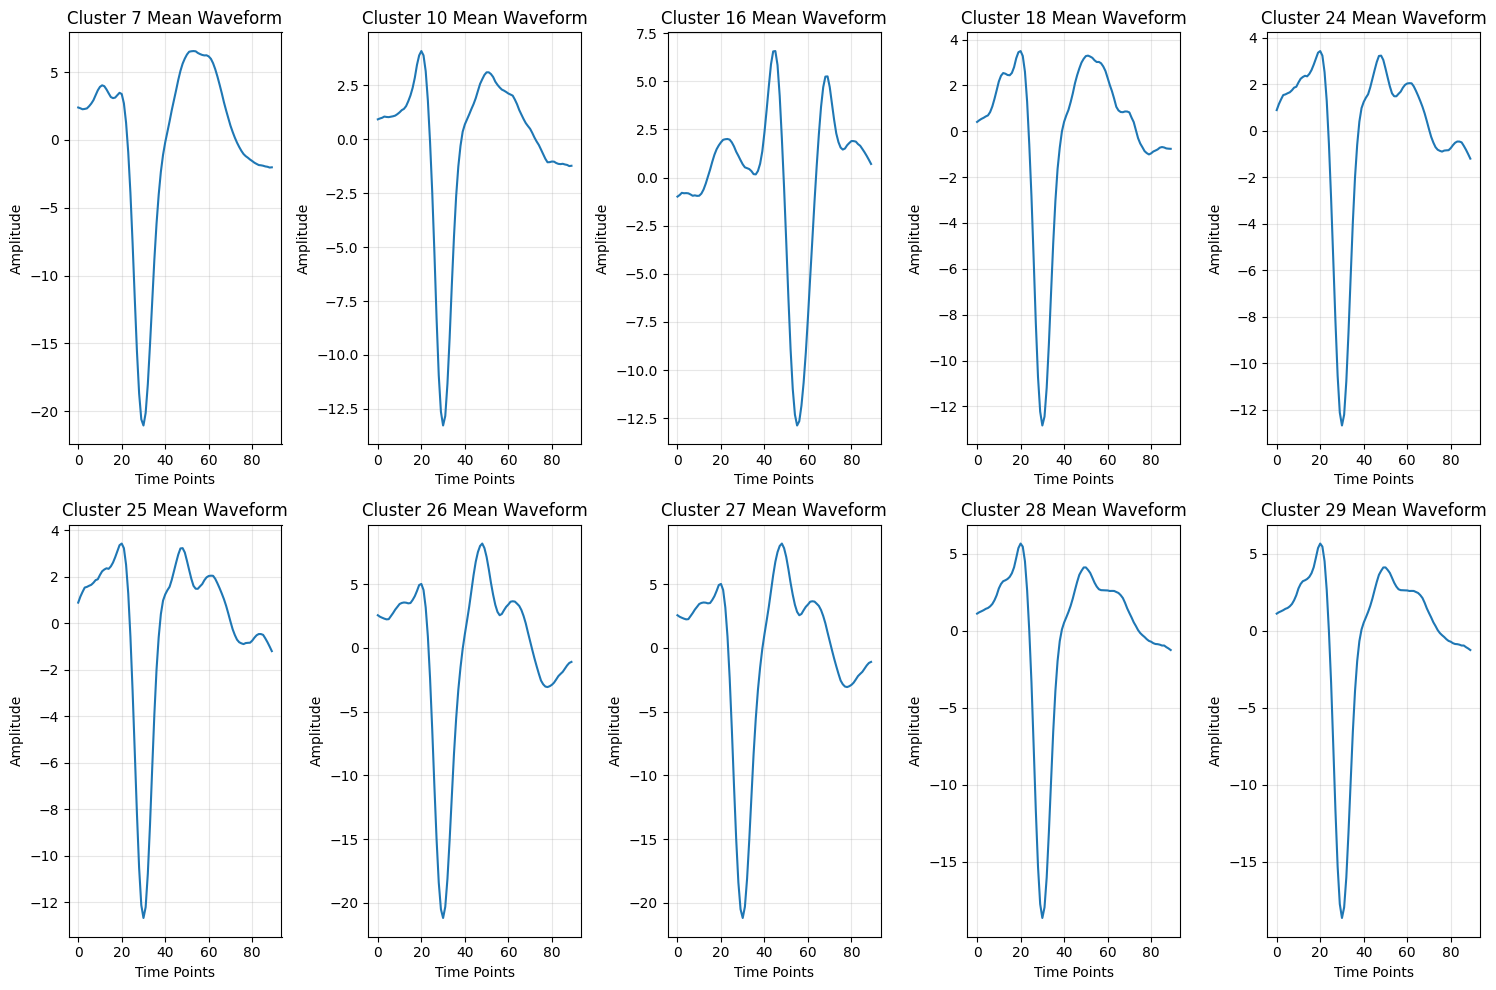

成功可视化 10 个cluster的展开waveform数据

使用示例:
# 访问cluster 0的所有waveform数据:
cluster_0_waveform = cluster_inf_expanded[cluster_inf_expanded['cluster_id'] == 0][waveform_columns].values[0]
# 访问cluster 0的第10个时间点的值:
cluster_0_timepoint_10 = cluster_inf_expanded[cluster_inf_expanded['cluster_id'] == 0]['mean_waveform_10'].values[0]


In [52]:
# 可视化展开后的waveform数据
import matplotlib.pyplot as plt

# 获取waveform列
waveform_columns = [col for col in cluster_inf.columns if col.startswith('mean_waveform_')]

if len(waveform_columns) > 0:
    # 选择前6个cluster进行可视化
    n_clusters_to_plot = min(10, len(cluster_inf))
    fig, axes = plt.subplots(2, 5, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(n_clusters_to_plot):
        row = cluster_inf.iloc[i]
        cluster_id = row['cluster_id']
        
        # 从展开的列中提取waveform数据
        waveform = row[waveform_columns].values
        
        
        axes[i].plot(waveform)
        axes[i].set_title(f'Cluster {cluster_id} Mean Waveform')
        axes[i].set_xlabel('Time Points')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True, alpha=0.3)
        
    for i in range(n_clusters_to_plot, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('/media/ubuntu/sda/cen/0912_results/Anesthesia_10min/waveform.png')

    plt.show()
    #plt.savefig('/media/ubuntu/sda/cen/0912_results/Anesthesia_10min/waveform.png')


    print(f"成功可视化 {n_clusters_to_plot} 个cluster的展开waveform数据")
    
    # 显示如何访问特定的waveform时间点
    print(f"\n使用示例:")
    print(f"# 访问cluster 0的所有waveform数据:")
    print(f"cluster_0_waveform = cluster_inf_expanded[cluster_inf_expanded['cluster_id'] == 0][waveform_columns].values[0]")
    print(f"# 访问cluster 0的第10个时间点的值:")
    print(f"cluster_0_timepoint_10 = cluster_inf_expanded[cluster_inf_expanded['cluster_id'] == 0]['mean_waveform_10'].values[0]")
    
else:
    print("没有找到waveform列数据")
